# Continuous DPPの核関数を積分することでfinite DPPに書き直すこと

In [1]:
from dppy.finite_dpps import FiniteDPP
import math
import matplotlib.pyplot as plt
import mpmath
import numpy as np
import pandas as pd
from scipy import special, integrate
import seaborn as sns

rng = np.random.default_rng()  # 乱数生成器を初期化。
sns.set()

def normalizedForSemiCircle(data):
    return data / np.sqrt(2 * matrixSize)

行列の大きさ、あるいは粒子数の期待値
$$
    n = 50
$$
直交関数系
$$
    \phi_l(x) = \frac{1}{\sqrt{2^l l!}} H_l\Bigl(\frac{x}{2}\Bigr)
$$
Reference測度
$$
    \mu(\mathrm{d}x) = \frac{\mathrm{e}^{-x^2 / 4}}{\sqrt{4\pi}} \mathrm{d}x
$$
核関数 $K\colon \mathbb{R}^2 \to \mathbb{R}$
$$
    K(x, y)
    = \sum_{l=0}^{n-1} \phi_l(x) \phi_l(y)
    = \sum_{l=0}^{n-1} \frac{H_l(x / 2) H_l(y / 2)}{2^l l!}
$$

In [2]:
matrixSize = 50
Hn0 = lambda x: mpmath.hermite(matrixSize, x)
Hn1 = lambda x: mpmath.hermite(matrixSize - 1, x)

def kernel(x, y):
    if x != y:
        return float((Hn0(0.5 * x) * Hn1(0.5 * y) - Hn1(0.5 * x) * Hn0(0.5 * y)) / (x - y) / mpmath.power(2, matrixSize - 1) / mpmath.factorial(matrixSize - 1))
    else:
        return float((matrixSize * Hn1(0.5 * x) * Hn1(0.5 * x) - x * Hn1(0.5 * x) * Hn0(0.5 * x) + mpmath.mpf('0.5') * Hn0(0.5 * x) * Hn0(0.5 * x)) / mpmath.power(2, matrixSize - 1) / mpmath.factorial(matrixSize - 1))

uKernel = np.vectorize(kernel)

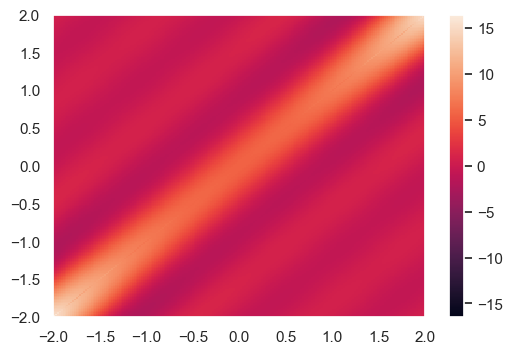

In [3]:
plt.rcParams['axes.grid'] = False
x, y = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
K = uKernel(x, y)
K = K[:-1, :-1]
fig, ax = plt.subplots(dpi=100)
c = ax.pcolorfast(x, y, K, vmin=-np.abs(K).max(), vmax=np.abs(K).max())
fig.colorbar(c, ax=ax)
plt.show()
plt.rcParams['axes.grid'] = True

区間
$$
    A = [-8, 8]
$$
1点相関関数の積分
$$
    \int_A \rho_1(x) \mu(\mathrm{d}x)
    = \int_A K(x, x) \mu(\mathrm{d}x)
    = \int_A \frac{1}{2^{n-1} (n-1)!} \left(n H_{n-1}\Bigl(\frac{x}{2}\Bigr)^2 - x H_{n-1}\Bigl(\frac{x}{2}\Bigr) H_{n}\Bigl(\frac{x}{2}\Bigr) + \frac{1}{2} H_{n}\Bigl(\frac{x}{2}\Bigr)^2\right) \frac{\mathrm{e}^{-\frac{x^2}{4}}}{\sqrt{4\pi}} \mathrm{d}x_1
$$

In [4]:
minA, maxA = -8, 8  # 小さく選ぶと行列の大きさの割に粒子数が少なくなり、大きく選ぶと分割数の多さの割に粒子数が少なくなる。
referenceDensity = lambda x: np.exp(-x**2 * 0.25) * 0.5 / np.sqrt(np.pi)
expectedNumber, _ = integrate.quad(lambda x: kernel(x, x) * referenceDensity(x), minA, maxA)
expectedNumber

23.453204267443148

上の核関数$K$ は連続関数だが、区間の分割を
$$
    A = \bigcup_{l=1}^{m} A_l
    = \bigcup_{l=1}^{m} \biggl[-8 + \frac{l}{m}\cdot 16, -8 + \frac{l+1}{m}\cdot 16\biggr)
    \quad
    (l = 0,\dots, m - 1)
$$
としたとき、これらを組み合わた領域上で積分することによって定義される行列を
$$
    \mathsf{K} = [\mathsf{K}_{i,j}]_{i,j=1}^{m} = \left[\iint_{A_i \times A_j} K(x, y) \mu(\mathrm{d}x) \mu(\mathrm{d}y)\right]_{i,j=1}^{m}
$$
とする。ここでは、分割数を1点関数の積分値の $1.5$ 倍とする；
$$
    m = \left\lceil \frac{3}{2} \int_A \rho_1(x) \mu(\mathrm{d}x) \right\rceil.
$$

Kernel:
 [[ 2.089e-08  2.339e-08 -1.468e-08 ...  1.334e-09 -4.358e-10 -8.439e-11]
 [ 2.339e-08  1.129e-07  1.160e-07 ...  1.038e-09  5.915e-10 -4.358e-10]
 [-1.468e-08  1.160e-07  5.477e-07 ... -9.060e-09  1.038e-09  1.334e-09]
 ...
 [ 1.334e-09  1.038e-09 -9.060e-09 ...  5.477e-07  1.160e-07 -1.468e-08]
 [-4.358e-10  5.915e-10  1.038e-09 ...  1.160e-07  1.129e-07  2.339e-08]
 [-8.439e-11 -4.358e-10  1.334e-09 ... -1.468e-08  2.339e-08  2.089e-08]]
Kernel size:  (36, 36)
Eigen values:
 [1.175e-01 1.031e-01 8.942e-02 7.620e-02 6.247e-02 4.995e-02 3.753e-02
 2.794e-02 1.912e-02 1.329e-02 8.276e-03 5.397e-03 3.053e-03 1.876e-03
 9.637e-04 5.607e-04 2.612e-04 1.444e-04 6.095e-05 3.214e-05 1.226e-05
 6.187e-06 2.127e-06 1.030e-06 3.176e-07 1.481e-07 3.975e-08 1.616e-08
 2.437e-09 6.341e-10 4.215e-11 7.328e-12 2.602e-13 2.058e-13 1.905e-14
 2.209e-15]


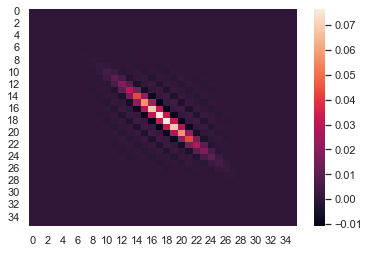

CPU times: total: 5min 33s
Wall time: 5min 45s


In [5]:
%%time
numDividing = math.ceil(expectedNumber * 1.5)
np.set_printoptions(precision=3)
x = np.linspace(minA, maxA, numDividing + 1)
y = np.linspace(minA, maxA, numDividing + 1)
correlationKernel = np.array([
    [integrate.dblquad(lambda x, y: kernel(x, y) * referenceDensity(x) * referenceDensity(y), x[i], x[i + 1], lambda x: y[j], lambda x: y[j + 1])[0]
    for i in range(numDividing)]
    for j in range(numDividing)], dtype=float)
print('Kernel:\n', correlationKernel)
print('Kernel size: ', correlationKernel.shape)
print('Eigen values:\n', np.linalg.eigvals(correlationKernel))
sns.heatmap(correlationKernel)
plt.show()

上で定義した行列 $\mathsf{K}$ をDPPyのFniniteDPPクラスに渡す。

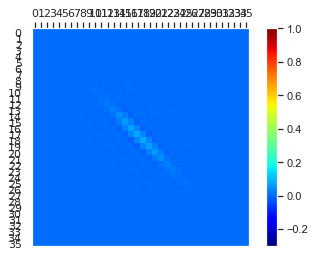

In [6]:
dpp = FiniteDPP('correlation', **{'K': correlationKernel})
dpp.plot_kernel()

FiniteDPPクラスを用いて$k$-DPPのサンプリングをする。結果は $0$ から $m$ 未満の整数が
$$
    k = \left\lfloor \int_A \rho_1(x) \mu(\mathrm{d}x) \right\rfloor
$$
の数だけ得られる。次の表の列 "label $i$" は $i$ 番目に引き出された $\{A_j\}_{j=1}^{m}$ の添字の意味である。行は何番目の試行かを意味する。

In [7]:
numTrial = 10
numPulled = math.floor(expectedNumber)

df = pd.DataFrame(
    [],
    index=range(1, numTrial + 1),
    columns=['label {}'.format(i + 1) for i in range(numPulled)] + ['x_{}'.format(i + 1) for i in range(numPulled)]
)

dpp.flush_samples()
for _ in range(numTrial):
    #dpp.sample_exact()  # 殆ど観測されない。高々1、2個程度。
    dpp.sample_exact_k_dpp(size=numPulled)
df.iloc[:, :numPulled] = dpp.list_of_samples
df[['label {}'.format(i + 1) for i in range(numPulled)]]

label 1 label 2 label 3 label 4 label 5 label 6 label 7 label 8 label 9  \
1       10      18      20       3      30      32       4       8      22   
2       13      25      26      10      23      11      12       9      20   
3        5      23      10      15      27      18      17      26       7   
4       31      14      27      22       8       3      24      15      30   
5       26       9      17       6      32      12      28      25      14   
6       12      16      27       5      19      13      24      11      30   
7       10      32      27      30      23      21      15      19       6   
8       13      21      20      10      22       8      31       3      12   
9       13      22      28      30      19      21      11      32      14   
10       4      24      12      18      28      16      32       9      13   

   label 10  ... label 14 label 15 label 16 label 17 label 18 label 19  \
1        17  ...       23       26       27       29        6       15   
2        16  ...       29       24       17        7       15        5   
3         8  ...       24       14       11        4       22       12   
4        17  ...        4       12        9       28       18        6   
5         8  ...       31       23       15       19       13        7   
6        17  ...        9       28       22       15        7       31   
7        18  ...        4       16        9       28       25       14   
8        28  ...        7       30       17       24        5       15   
9        20  ...        9        5        7       26       12        4   
10        5  ...        2       17        6       27       22       31   

   label 20 label 21 label 22 label 23  
1         9       25        7       14  
2        22        3       18       28  
3        13       31       29        3  
4        16       26        7       21  
5        20       18       21       24  
6        21        4       23       20  
7        22       17       11        8  
8        16       11       27       26  
9         8        1       15       29  
10       20       11       23       21  

[10 rows x 23 columns]

前のセルで得られた番号の集合を $\mathcal{N}$ とする。各 $i\in\mathcal{N}$ に対して独立な一様乱数 $X_i\sim\mathrm{Unif}(A_i)$ を生成することによって、DPPの標本 $\{X_i\}_{i\in\mathcal{N}}$ を定める。

In [8]:
def uniformOnPartition(indices):
    if indices:
        return list(map(lambda index: rng.uniform(x[index], x[index + 1]), indices))
    else:
        return []

df.iloc[:, numPulled:] = list(map(uniformOnPartition, dpp.list_of_samples))
df[['x_{}'.format(i + 1) for i in range(numPulled)]]

x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
1  -3.531328  0.271429  0.984549 -6.568861  5.581334  6.414102 -6.104647   
2  -1.878103  3.132049    3.9439 -3.422168   2.59713 -3.028319 -2.549532   
3  -5.704624  2.440685 -3.127201 -1.200814  4.351062  0.259031 -0.184362   
4   6.047805 -1.525184  4.170348  2.098903 -4.012894 -6.440312  3.077235   
5   3.946737 -3.702331 -0.103469 -5.120969  6.649145 -2.350909  4.878888   
6  -2.260446 -0.574092  4.166504 -5.677174  0.517703 -2.103205  2.782227   
7  -3.356082  6.232999  4.439493  5.451108  2.464864  1.775535 -1.002805   
8     -1.842  1.424382  1.057403 -3.126867  1.916625 -4.029042  6.106188   
9  -1.886339  2.137915    4.7093  5.350295  0.522122  1.745181  -3.08148   
10  -5.89841  2.688418 -2.241849  0.085358  4.668864 -0.654978  6.436953   

         x_8       x_9      x_10  ...      x_14      x_15      x_16      x_17  \
1  -4.220555  1.810773 -0.369536  ...  2.525267  3.721609  4.350311  5.155241   
2   -3.69555  1.228124 -0.775919  ...  5.220203  2.811452 -0.051282 -4.795756   
3   3.602466 -4.796581 -4.030953  ...  2.869325  -1.52031 -3.098013 -5.794733   
4  -0.988454  5.496884 -0.326454  ... -6.102712 -2.514108 -3.695252  4.796234   
5   3.473215 -1.702427  -4.11406  ...  6.136356  2.501007 -1.138113   0.60356   
6  -2.792694  5.452014 -0.188546  ... -3.633083  4.834911  2.051969 -1.052319   
7   0.747809 -5.057431  0.399184  ... -5.989016 -0.695476 -3.573472   4.47022   
8  -6.610853  -2.46429  4.551776  ... -4.807984  5.634966 -0.141477  2.955742   
9   6.301339 -1.359041  1.306253  ... -3.741068 -5.676638 -4.866587  3.687502   
10 -3.872918 -1.891799 -5.484238  ... -6.694253 -0.376958 -5.069019  4.340986   

        x_18      x_19      x_20      x_21      x_22      x_23  
1  -4.941761 -0.956137 -3.676562  3.291907 -4.618995 -1.478621  
2  -1.212028 -5.633477  2.179299  -6.34763  0.201322  4.651186  
3   2.044462 -2.356244 -1.931736  6.130754  5.179133 -6.340468  
4   0.192161 -4.921813 -0.795832  3.856651 -4.706475  1.542388  
5  -1.778994 -4.542332  1.247191  0.423998  1.708673  2.717452  
6  -4.536925  6.202417  1.395573 -5.847957  2.656291  1.332234  
7   3.260116 -1.737478  2.178322 -0.392988 -2.999361 -4.394416  
8  -5.420145 -1.177114 -0.444815 -2.935188  4.074248  3.706818  
9  -2.475018  -6.10808 -4.135956   -7.1391 -1.030289  5.325763  
10  2.041073   6.14469  1.165874 -3.107907  2.228335   1.45588  

[10 rows x 23 columns]

In [9]:
sample = df.loc[numTrial, ['x_{}'.format(i + 1) for i in range(numPulled)]]
sns.scatterplot(x=sample, y=np.zeros(len(sample)))
plt.show()
sns.histplot(data=sample, bins=20, stat='density')  # ヒストグラムを描画。
plt.show()